# Лабораторная работа №6 по курсу "Численные методы"
## Тема ЛР - "Начально-краевые задачи для дифференциального уравнения гиперболического типа"

Студент - Письменский Данила Владимирович

Группа - М8О-406Б-19

## Задание

Используя явную схему крест и неявную схему, решить начально-краевую задачу для дифференциального уравнения гиперболического типа. Осуществить реализацию трех вариантов аппроксимации граничных условий, содержащих производные: двухточечная аппроксимация с первым порядком, трехточечная аппроксимация со вторым порядком, двухточечная аппроксимация со вторым порядком. В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением *U(x, t)*.

### Вариант 3  
$\large\frac{\partial^2 u}{\partial t^2} = \frac{\partial^2 u}{\partial x^2} -3u$  
$u(0,t) = sin(2t)$  
$u(\pi,t) = -sin(2t)$  
$u(x,0) = 0$  
$u_t(x,0) = 2cos(x)$  
Аналитическое решение: $U(x,t) = cos(x)sin(2x)$ 

In [1]:
# импортируем библиотеки
import numpy as np
import matplotlib.pyplot as plt

Зададим начальные условия, а также коэффициенты *a*, *sigma* и *h* - размер сетки для координатной составляющей. Размер сетки для временной составляющей будем искать из формулы $\tau = \sqrt {\sigma h^2} $.
### Константы

In [2]:
x_start = 0
x_end = np.pi

t_start = 0
t_end = 5

h = 0.01
sigma = 1

### Начальные условия

In [3]:
def phi_0(t):
    return np.sin(2 * t)

def phi_1(t):
    return -np.sin(2 * t)

def psi_0(x):
    return 0

def psi_1(x):
    return 2 * np.cos(x)

def exact_sol(x, t):
    return np.cos(x) * np.sin(2 * t)

### Аналитическое решение
Найдем аналитическое решение начально-краевой задачи для дифференциального уравнения гиперболического типа, затем будем сравнивать его с численными методами для того. Это нам пригодится, чтобы визуализировать зависимость максимального модуля ошибки от времени. Для этого реализовал функцию, которая возвращает матрицу *U* со значениями функции для аналитического решения.

In [4]:
def analytical_solve(x_start, x_end, t_start, t_end, h, sigma):
    tau = np.sqrt(sigma * h**2)
    x = np.arange(x_start, x_end, h)
    t = np.arange(t_start, t_end, tau)

    U = np.zeros((len(t), len(x)))
    for dx in range(len(x)):
        for dt in range(len(t)):
            U[dt][dx] = exact_sol(x[dx], t[dt])
    return U

In [5]:
anal_solution = analytical_solve(x_start, x_end, t_start, t_end, h, sigma)

In [6]:
anal_solution.shape

(500, 315)

### Погрешность
В качестве погрешности буду использовать максимальный модуль ошибки.

In [7]:
def max_abs_error(U_num, U_anal):
    return abs(U_num - U_anal).max()

### Реализация функций построения графиков
Для того, чтобы визуализировать решение ДУ численными методами, реализую функцию построения графика функции *U(t)* при заданном времени *t*.

In [8]:
def build_numerical_results_graphic(solution, method_name, time, x_start, x_end, t_start, t_end, h, sigma):
    tau = np.sqrt(sigma * h**2)
    x = np.arange(x_start, x_end, h)
    times = np.arange(t_start, t_end, tau)
    cur_t_id = abs(times - time).argmin()

    plt.figure(figsize=(15, 9))
    plt.plot(x, anal_solution[cur_t_id], label='Аналитическое решение')
    plt.plot(x, solution[cur_t_id], label=method_name, color='r')
    
    plt.xlabel('x')
    plt.ylabel('U(t)')
    plt.legend()
    plt.grid()
    plt.show()

Чтобы проверить, наскольно точно решение ДУ численными методами, необходимо реализовать функцию построения графика зависимости погрешности (максимального модуля ошибки) от времени.

In [9]:
def build_errors_graphic(solution, method_name, t_start, t_end, h, sigma):
    tau = np.sqrt(sigma * h**2)
    t = np.arange(t_start, t_end, tau)

    plt.figure(figsize=(15, 9))
    max_abs_errors = np.array([max_abs_error(solution[i], anal_solution[i]) for i in range(len(t))])
    plt.plot(t, max_abs_errors, label=method_name, color='g')

    plt.xlabel('Время')
    plt.ylabel('Максимальный модуль ошибки')

    plt.legend()
    plt.grid()
    plt.show()

## Численные методы

### Явная конечно-разностная схема

Преобразуем исходное уравнение с производными в уравнение с их численными приближениями. Производную второго порядка в правой части уравнения будем аппроксимировать по значениям нижнего временного слоя.  

$\large\frac{\partial^2 u}{\partial t^2} = \frac{\partial^2 u}{\partial x^2} - 3u;$  
$\large{{u^{k+1}_j - 2u^k_j+ u^{k-1}_j} \over {\tau^2}} = {{u^k_{j-1} - 2u^k_j+ u^k_{j+1}} \over {h^2}} -3u^k_j=>$
$\large u^{k+1}_j$ = ${\tau^2 \over h^2}(u^k_{j-1}-2u^k_j+u^k_{j+1}) + (2-3\tau^2)u^k_j-u^{k-1}_j$

Для нижнего временного ряда:  
$u^0_j=\psi_1(x_j)$  
$u^1_j=\psi_1(x_j) + \tau\psi_2(x_j)$  

Получили рекуррентное соотношение. Начальные условия позволяет нам посчитать значения *u* в нижнем временном ряду. Далее в цикле считаем значения в узлах сетки.  

Особенностью метода явной конечно-разностной схемы является условие $\sigma={{\tau^2} \over {h^2}} < 1$, при котором данный метод условно устойчив. В противном случае, погрешность вычисления будет очень большой.  

*Заметим, что повышение порядка аппроксимации для $u^1_j$ не имеет смысла, т.к. в данном варианте лабораторной работы $\psi_1 = 0$, вторая производная которой равна 0.*

In [12]:
def explicit_finite_difference_method(x_start, x_end, t_start, t_end, h, sigma, phi_0, phi_1, psi_0, psi_1):
    tau = np.sqrt(sigma * h**2)
    x = np.arange(x_start, x_end, h)
    t = np.arange(t_start, t_end, tau)

    U = np.zeros((len(t), len(x)))
    # подсчитываем значения, используя начальное условие 0
    for i in range(len(x)):
        U[0][i] = psi_0(x[i])

    # используем аппроксимацию
    for i in range(len(x)):
        U[1][i] = psi_0(x[i]) + tau * psi_1(x[i])
        
    for dt in range(2, len(t)):
        # подсчитываем значения, используя граничное условие 0
        U[dt][0] = phi_0(t[dt])
        # явная схема
        for dx in range(1, len(x) - 1):
            U[dt][dx] = sigma*(U[dt-1][dx+1] - 2*U[dt-1][dx] + U[dt-1][dx-1]) + (2 - 3*tau**2) * U[dt-1][dx] - U[dt-2][dx]
        # подсчитываем значения, используя граничное условие 1
        U[dt][-1] = phi_1(t[dt])
    return U

In [13]:
explicit_solution = explicit_finite_difference_method(x_start, x_end, t_start, t_end, h, sigma, phi_0, phi_1, psi_0, psi_1)

In [14]:
explicit_solution.shape

(500, 315)

### Максимальный модуль ошибки

In [29]:
print(f'Максимальный модуль ошибки = {max_abs_error(explicit_solution, anal_solution)}')

Максимальный модуль ошибки = 0.00010771631560224648


### Визуализация решения ДУ с помощью явной конечно-разностной схемы

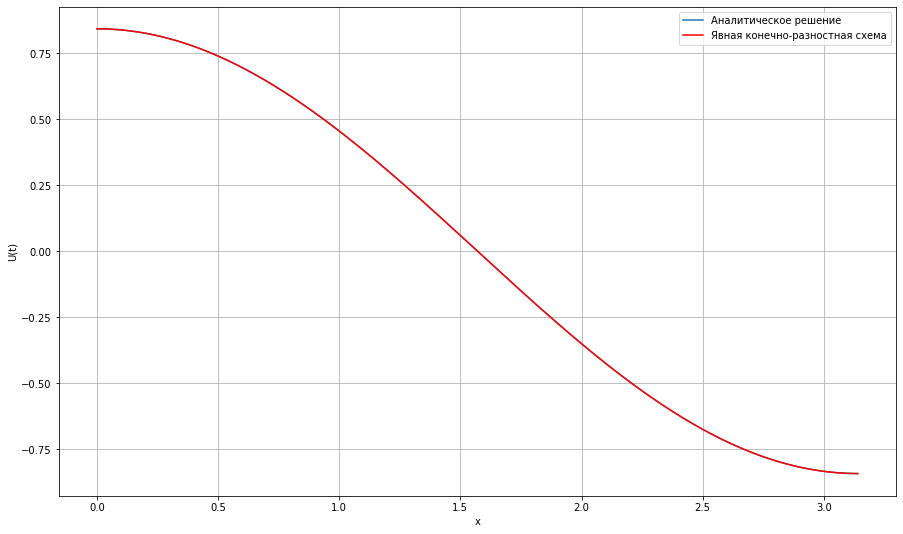

In [16]:
build_numerical_results_graphic(explicit_solution, "Явная конечно-разностная схема", 0.5, x_start, x_end, t_start, t_end, h, sigma)

### Визуализация погрешности метода явной конечно-разностной схемы

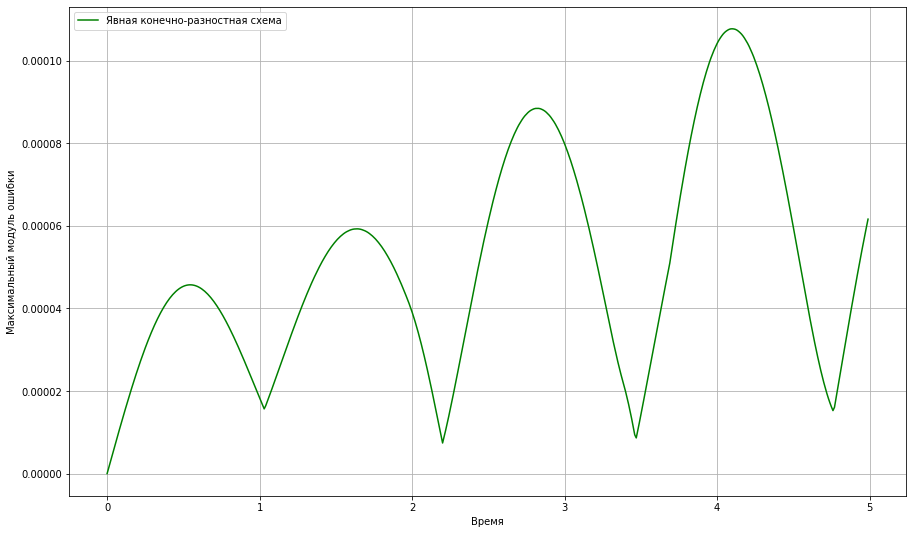

In [17]:
build_errors_graphic(explicit_solution, "Явная конечно-разностная схема", t_start, t_end, h, sigma)

### Неявная конечно-разностная схема

Преобразуем исходное уравнение с производными в уравнение с их численными приближениями. Производную второго порядка в правой части уравнения будем аппроксимировать по значениям нижнего временного слоя.  

Необходимо решить систему уравнений для того, чтобы получить значения *u* в одном временном ряду.  
Система уравнений имеет вид:  
\begin{cases} b_1u^{k+1}_1 + c_1u^{k+1}_2=d_1, \ j=1\\ a_ju^{k+1}_{j-1}+b_ju^{k+1}_{j} + c_ju^{k+1}_{j + 1} = d_j, \ j=2...(n-2) \\ a_{n-1}u^{k+1}_{n-2} + b_{n-1}u^{k+1}_{n-1}=d_{n-1}, \ j=n-1  \quad,где\end{cases}  
$a_j=c_j=\sigma= {{\tau^2} \over {h^2}}$  
$b_j=-3\tau^2 -2\sigma - 1$  
$d_j=u^{k-1}_j -2u^k_j , \ j=2...(n-2)$  
$d_1=-\sigma\phi_0(t^{k+1}) - u^k_1$  
$d_{n-1}=-\sigma\phi_1(t^{k+1}) - u^k_{n-1}$  

Данная система уравнений представляет собой трёхдиагональную СЛАУ, которую можно решить, используя метод прогонки.

### Метод прогонки

In [18]:
def run_through_method(A, b):
    n = len(A)
    
    v = [0 for _ in range(n)]
    u = [0 for _ in range(n)]
    v[0] = A[0][1] / -A[0][0]
    u[0] = b[0] / A[0][0]
    for i in range(1, n - 1):
        v[i] = A[i][i + 1] / (-A[i][i] - A[i][i - 1] * v[i - 1])
        u[i] = (A[i][i - 1] * u[i - 1] - b[i]) / (-A[i][i] - A[i][i - 1] * v[i - 1])
    v[n - 1] = 0
    u[n - 1] = (A[n - 1][n - 2] * u[n - 2] - b[n - 1]) / (-A[n - 1][n - 1] - A[n - 1][n - 2] * v[n - 2])

    x = [0 for _ in range(n)]
    x[n - 1] = u[n - 1]
    for i in range(n - 1, 0, -1):
        x[i - 1] = v[i - 1] * x[i] + u[i - 1]
    return np.array(x)

In [19]:
def implicit_finite_difference_method(x_start, x_end, t_start, t_end, h, sigma, phi_0, phi_1, psi_0, psi_1):
    tau = np.sqrt(sigma * h**2)
    x = np.arange(x_start, x_end, h)
    t = np.arange(t_start, t_end, tau)
    U = np.zeros((len(t), len(x)))

    # подсчитываем значения, используя начальное условие 0
    for i in range(len(x)):
        U[0][i] = psi_0(x[i])
        
    # используем аппроксимацию
    for dx in range(len(x)):
        U[1][dx] = psi_0(x[dx]) + tau * psi_1(x[dx])
    
    for dt in range(2, len(t)):
        A = np.zeros((len(x) - 2, len(x) - 2))
        A[0][0] = -3 * tau ** 2 - 2 * sigma - 1
        A[0][1] = sigma
        for i in range(1, len(A) - 1):
            A[i][i - 1] = sigma
            A[i][i] = -3 * tau ** 2 - 2 * sigma - 1
            A[i][i + 1] = sigma
        A[-1][-2] = sigma
        A[-1][-1] = -3 * tau ** 2 - 2 * sigma - 1
        
        b = -2 * U[dt - 1][1:-1] + U[dt - 2][1:-1]
        # подсчитываем значения, используя граничные условия
        b[0] -= sigma * phi_0(t[dt])
        b[-1] -= sigma * phi_1(t[dt])

        U[dt][0] = phi_0(t[dt])
        U[dt][-1] = phi_1(t[dt])
        # метод прогонки
        U[dt][1:-1] = run_through_method(A, b)
    return U

In [20]:
implicit_solution = implicit_finite_difference_method(x_start, x_end, t_start, t_end, h, sigma, phi_0, phi_1, psi_0, psi_1)

In [21]:
implicit_solution.shape

(500, 315)

### Максимальный модуль ошибки

In [30]:
print(f'Максимальный модуль ошибки = {max_abs_error(implicit_solution, anal_solution)}')

Максимальный модуль ошибки = 0.04138708853076888


### Визуализация решения ДУ с помощью явной конечно-разностной схемы

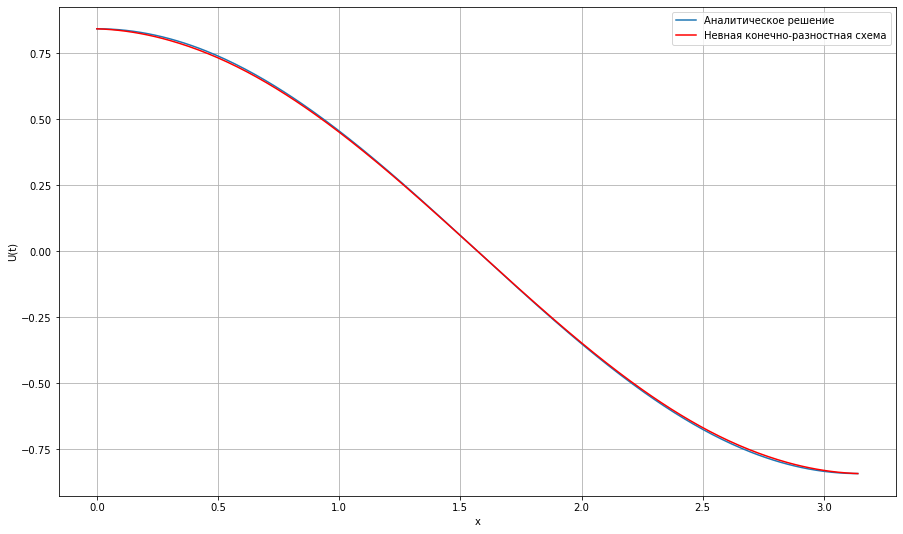

In [23]:
build_numerical_results_graphic(implicit_solution, "Невная конечно-разностная схема", 0.5, x_start, x_end, t_start, t_end, h, sigma)

### Визуализация погрешности метода явной конечно-разностной схемы

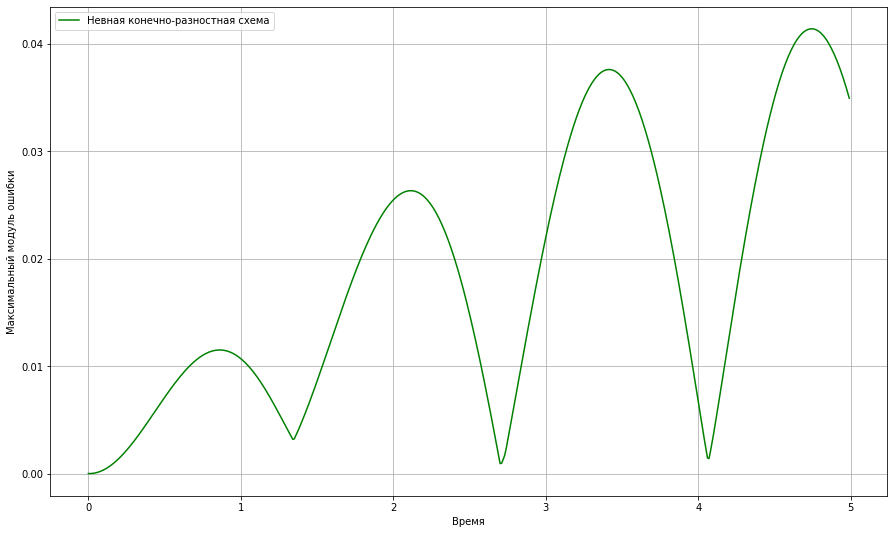

In [24]:
build_errors_graphic(implicit_solution, "Невная конечно-разностная схема", t_start, t_end, h, sigma)

### Сравнение численных методов с аналитическим решением

In [25]:
def build_all_numerical_results_graphic(sol1, sol2, m_n1, m_n2, time, x_start, x_end, t_start, t_end, h, sigma):
    tau = np.sqrt(sigma * h**2)
    x = np.arange(x_start, x_end, h)
    times = np.arange(t_start, t_end, tau)
    cur_t_id = abs(times - time).argmin()

    plt.figure(figsize=(15, 9))
    plt.plot(x, anal_solution[cur_t_id], label='Аналитическое решение')
    plt.plot(x, sol1[cur_t_id], label=m_n1, color='r')
    plt.plot(x, sol2[cur_t_id], label=m_n2, color='m')
    
    plt.xlabel('x')
    plt.ylabel('U(t)')
    plt.legend()
    plt.grid()
    plt.show()

In [26]:
def build_all_errors_graphic(sol1, sol2, m_n1, m_n2, t_start, t_end, h, sigma):
    tau = np.sqrt(sigma * h**2)
    t = np.arange(t_start, t_end, tau)

    plt.figure(figsize=(15, 9))
    max_abs_errors1 = np.array([max_abs_error(sol1[i], anal_solution[i]) for i in range(len(t))])
    max_abs_errors2 = np.array([max_abs_error(sol2[i], anal_solution[i]) for i in range(len(t))])
    plt.plot(t, max_abs_errors1, label=m_n1, color='g')
    plt.plot(t, max_abs_errors2, label=m_n2, color='r')

    plt.xlabel('Время')
    plt.ylabel('Максимальный модуль ошибки')

    plt.legend()
    plt.grid()
    plt.show()

### Визуализация результатов работы численных методов

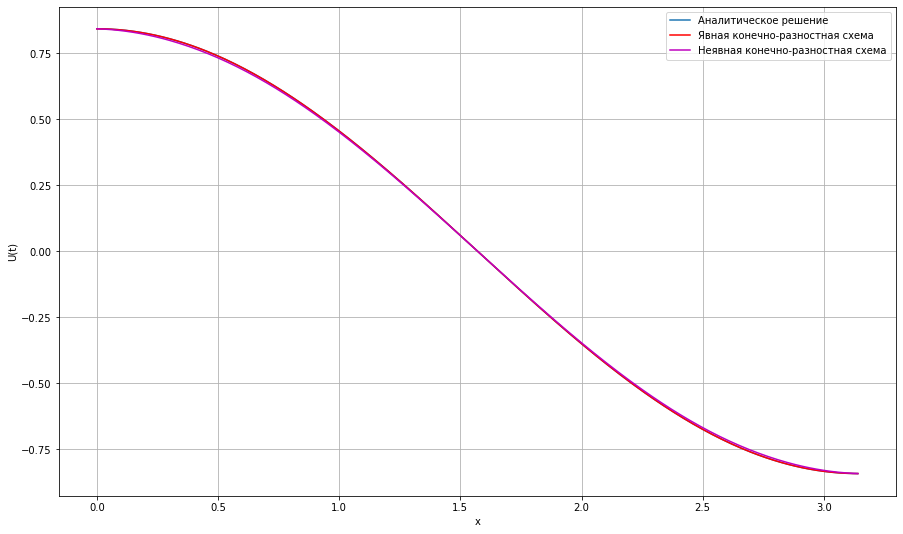

In [27]:
build_all_numerical_results_graphic(explicit_solution, implicit_solution, "Явная конечно-разностная схема", "Неявная конечно-разностная схема", 0.5, x_start, x_end, t_start, t_end, h, sigma)

### Визуализация зависимости погрешности от времени для численных методов

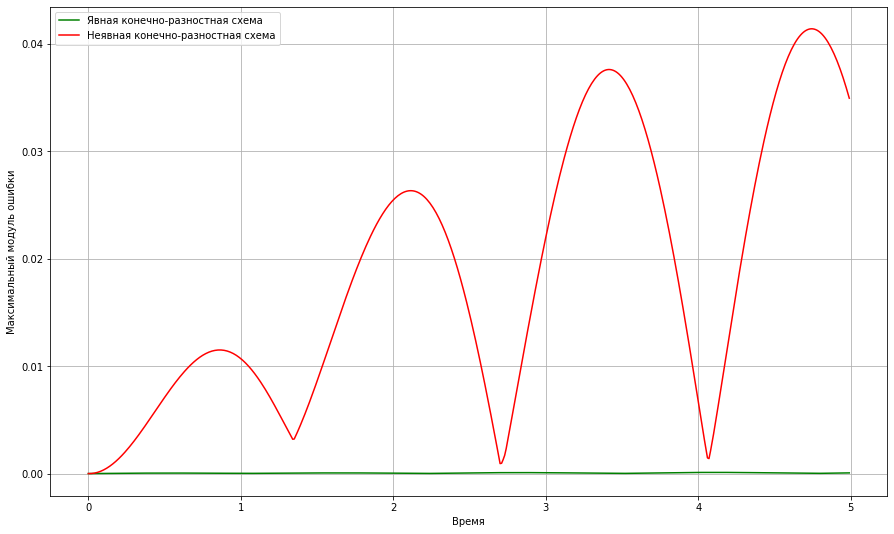

In [28]:
build_all_errors_graphic(explicit_solution, implicit_solution, "Явная конечно-разностная схема", "Неявная конечно-разностная схема", t_start, t_end, h, sigma)

### Выводы
В данной лабораторной работе изучил 2 метода для решения начально-краевой задачи для дифференциального уравнения гиперболического типа:
- явная конечно-разностная схема;
- неявная конечно-разностная схема. 

Полученное решение заданного ДУ данными методами имеет довольно большую точность. Построил графики зависимости погрешности от времени для всех численных методов.  

Явная конечно-разностная схема проста в реализации, однако может быть реализована только при условии $\sigma < 1$, т.е данный метод условно устойчив.  
Неявная конечно-разностная схема обуславливается сложностью вычислений, так как необходимо решать большое количество СЛАУ, однако в отличие от предыдущего метода данная схема является абсолютно устойчивой, т.е. не зависящей от $\sigma$.